### 摘要
---
- 本文深入浅出介绍了最小方差组合的理论与实践，2007年至今以上证50为基准的回测显示，组合年化波动率为26.4%，低于基准的31.2%，在收益上最小方差组合表现平平（对收益更感兴趣的矿友，可以参考资产配置后续文章，风险平价risk parity）
- 在回测上,文中首次采用**`动态Universe`**的方法，对`幸存者偏差`还不熟悉的矿友建议好好看一下文中推荐的研究文章
- 文中分享了诸多笔者平时研究的常用工具函数（包括最小方差组合构建相关），感兴趣者可以克隆自行使用

### 前言
---

- 1、资产配置是个很广泛的话题，配置的过程也算是个间接择时的过程，因为高配的资产必然是投资者综合其收益与风险考量后非常看好的

- 2、从使用场景分类上来看，资产配置可以是宏观的资产配置，比如货币类、债券类、权益类之间的配置；当然也可以是某一大类资产下的配置，比如在沪深300成分股不同标的之间的权重配置

- 3、但不管怎么说，从方法层面上看，对于不同场景下的使用都是一致的，只不过需要注意不同场景使用下的一些特殊处理

- 4、本篇作为资产配置研究系列的第一篇，从最简单的最小方差组合入手，理论结合实践，深入浅出

- 5、后续会根据时间安排，逐步介绍资产配置领域的相关理论与实践


### 最小方差组合简介
---

- 1、先从校园版开始，CAPM给我们提供了一条有效前沿(efficient frontier)，不在有效前沿上的风险组合都是不值得我们去投资的；其实，简单来讲就是要满足在一定风险情况下我们要追求收益最高，或者叫在给定收益约束下追求风险最低；这里面其实已经包含了组合分析的精髓：风险和收益之间的权衡

- 2、在实践中，我们会综合考虑收益和风险来构建投资组合，在数学上可以用最大化投资效用来求解投资组合，表示如下：
$$max \quad {\boldsymbol u' \boldsymbol w}-{\frac{\lambda}{2}\boldsymbol w'\boldsymbol \Omega \boldsymbol w}$$
$$\boldsymbol w' \boldsymbol 1 = 1$$
$$ w_i \geq 0$$
		上式中：$\boldsymbol u$ 为资产的预期收益率（n*1列向量，其余的类似），$\boldsymbol w$为资产权重，$\lambda$为投资者风险厌恶系数，$\boldsymbol \Omega$为方差协方差矩阵

- 3、对于不同的投资经理，最后构建组合的过程归根到底都是优化求解一个庞大的二次规划问题，只是形式上比上式要复杂好多；比如，在目标函数中可以引入交易成本、在约束条件中可以加入行业或风格限制等

- 4、在实际的会发现，预期收益率的好坏对模型结果影响很大，换句话说，优化结果对参数$u$极其敏感；而且对于预期收益的估计也是最难最没有把握的，基于此，很多人就在目标函数中放弃收益项，进而转变为最小化组合风险，如下是所示：
$$min \quad  \frac{1}{2}\boldsymbol \omega' \boldsymbol \Omega \boldsymbol \omega$$
$$\boldsymbol w' \boldsymbol1 = 1$$
$$ w_i \geq 0$$

- 5、至此，便可以构建最小方差组合，可以看到只需要估计出资产间的`方差协方差矩阵`便可以得到最小方差下的权重配置


### 估计协方差矩阵
---
- 根据如上分析，可以看到资产配置问题的核心在于协方差矩阵的估计，下面提供两种常见的实践方法

- **方法1：根据历史数据直接估计**
		- 直接用历史数据来估计是最简单易用的方法之一，直接取过去一段时间的历史行情，计算资产收益间的协方差矩阵即可
		- 一般来说，上面说的一段时间尽量是越长越好；当然还需要综合考虑你的投资时间跨度(invest horizon)
		- 另外，估计协方差是可以考虑引入EWMA，简单讲就是离现在更近的数据具有更高的权重
		- 当然，更多细节的地方每个人都有自己的处理方式，但整体来说直接用历史数据估计是个非常具有实践价值的方法
			
- **方法2：依赖风险模型**
		- 风险模型的使用场景更多集中于权益类，也就是前面提到的某一大类资产下的配置问题
		- 从美国市场上看，其已经有诸多专门做风险模型的公司，比如MSCI（Barra）、Axioma、Northfield
		- 应用第三方已有的风险模型，我们可以更准确地估计出组合的风险，也就是说，上述第三方公司已经帮我们完成了估计协方差的过程
---
实际中，个人很少有财力去买第三方的风险模型，哪怕是机构也很少；所以下面将用方法1来进行资产配置实例介绍

In [1]:
import numpy as np
import pandas as pd
import cvxopt as opt
import seaborn as sns
import matplotlib.pyplot as plt
from cvxopt import solvers, matrix
from scipy.optimize import minimize

pd.set_option('display.max_columns', None)  # 最多所有列
pd.set_option('display.max_rows', None)  # 显示所有行
# pd.set_option('display.float_format',lambda x: '%.6f'%x) # #显示小数位数两位
pd.set_option('display.width', 1024)  # 显示宽度
# pd.set_option('precision', 1)   # 设置显示数值的精度

import warnings
warnings.filterwarnings('ignore')  # 关闭运行时的警告
np.set_printoptions(linewidth=100, suppress=True)   # 打印numpy时设置显示宽度，并且不用科学计数法显示
print('载入完成')

载入完成


#### 先给出简单估算协方差矩阵的工具函数（细节与优化部分仁者见仁智者见智，这里不深入讨论）

#### 比如，输入所有备选股和日期，就可以获得协方差矩阵，如下代码就是简单的实例

            芯片ETF_159995.ZOF  消费ETF_159928.ZOF  银行基金_512700.HOF  证券ETF_512880.HOF  酒ETF_512690.HOF  医药ETF_512010.HOF  军工基金_512680.HOF  传媒ETF_512980.HOF  新能车_515700.HOF  有色金属_512400.HOF  环保ETF_512580.HOF  5GETF_515050.HOF  农业ETF_159825.ZOF  科创50_588000.HOF  化工ETF_159870.ZOF  纳指ETF_513100.HOF  中概互联_513050.HOF  AI智能_159819.ZOF  房地产_512200.HOF  家电ETF_159996.ZOF  恒生ETF_159920.ZOF  华宝油气_162411.ZOF
date                                                                                                                                                                                                                                                                                                                                                                                                      
2021-08-17         -0.043632         -0.036735        -0.009095         -0.006443        -0.046753         -0.035141        -0.016579         -0.023461       -0.017049        -0.008511         -0.007838        

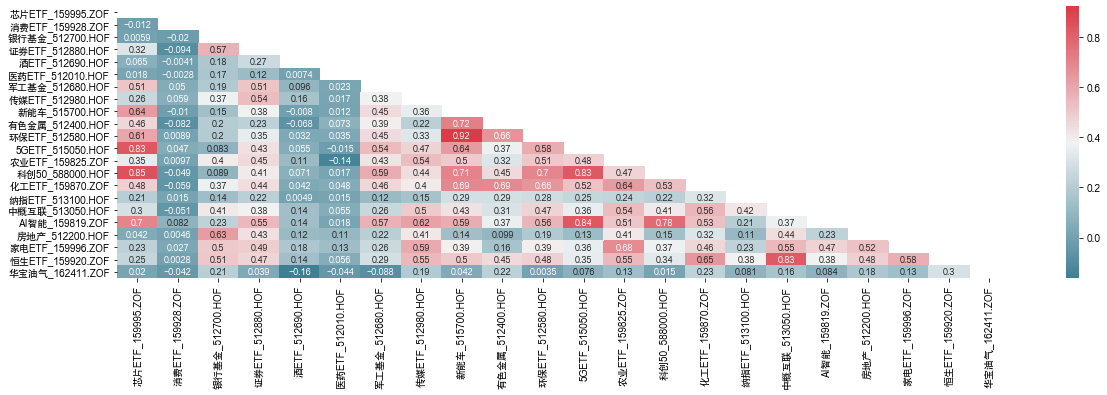

In [3]:
start_date = '2021-01-01'  # 回测开始时间
end_date = '2021-09-01'  # 结束时间

# instruments = ['510300.HOF','159940.ZOF','512700.HOF','512880.HOF','512690.HOF','512010.HOF','512680.HOF','512980.HOF','515700.HOF','512400.HOF','512580.HOF','515050.HOF','510500.HOF','159825.ZOF','588000.HOF','159870.ZOF','513100.HOF','513500.HOF','513050.HOF','159902.ZOF']  # 现有行业轮动组合
# instruments =  ['518880.HOF','510300.HOF','510500.HOF','588000.HOF','513100.HOF','513050.HOF','513080.HOF','513030.HOF','164824.ZOF','162411.ZOF','513520.HOF','159949.ZOF','161126.ZOF','161128.ZOF','513550.HOF']  # 多市场组合 
instruments =  ['159995.ZOF','159928.ZOF','512700.HOF','512880.HOF','512690.HOF','512010.HOF','512680.HOF','512980.HOF','515700.HOF','512400.HOF','512580.HOF','515050.HOF','159825.ZOF','588000.HOF','159870.ZOF','513100.HOF','513050.HOF','159819.ZOF','512200.HOF','159996.ZOF','159920.ZOF','162411.ZOF']  # 纯行业组合

# instruments = ['159870.ZOF','513100.HOF','513500.HOF','513050.HOF','159902.ZOF']  # for test
df_rtn = pd.DataFrame()

for i in range(len(instruments)):
    df_bar = DataSource('bar1d_CN_FUND').read(instruments[i], start_date=start_date, end_date=end_date, fields = ['instrument', 'date', 'close'])[-120:]  # 查询历史行情
    if instruments[i] in ['159870.ZOF']:
        df_info = pd.DataFrame(columns=['display_name'], index=[0])
        df_info['display_name'] = '化工ETF'
    else:
        df_info = DataSource('basic_info_CN_FUND').read(instruments[i])  # 查询基金的基本信息
    if not df_bar.empty and not df_info.empty:
    #     df.sort_values('date', inplace = True)
        df_bar[df_info.loc[0, 'display_name'] + '_' + instruments[i]] = np.log(df_bar['close'] / df_bar['close'].shift(1))
        df = df_bar[['date', df_info.loc[0, 'display_name'] + '_' + instruments[i]]]
        if df_rtn.empty:
            df_rtn = df
        else:
            df_rtn = df_rtn.merge(df, on=['date'])
df_rtn.set_index('date', drop=True, inplace=True)
df_rtn = df_rtn[1:]
# df_rtn['shibor'] = 0.02/250  # 采用shibor的隔日利率作为无风险收益，近似年化为2%
print(df_rtn.tail())

# 绘制相关系数热力图
mask = np.zeros_like(df_rtn.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(20,5))
sns.heatmap(df_rtn.corr(), mask=mask, annot=True, annot_kws={'size':9,'weight':'bold'}, cmap=cmap)
plt.show()

In [68]:
df_rtn.mean() * 250
# df_rtn.std() * np.sqrt(250)
# cov_mat = df_rtn.cov()*250  # 年化协方差矩阵
# cov_mat.head()

黄金ETF_518880.HOF    -0.031453
300ETF_510300.HOF   -0.290700
500ETF_510500.HOF    0.145734
科创50_588000.HOF      0.234719
纳指ETF_513100.HOF     0.205414
标普500_513500.HOF     0.279975
中概互联_513050.HOF     -0.968099
恒生ETF_159920.ZOF    -0.284502
法国ETF_513080.HOF     0.344216
德国30_513030.HOF      0.196849
印度基金_164824.ZOF      0.138934
华宝油气_162411.ZOF      0.248093
信诚商品_165513.ZOF      0.294146
日经ETF_513520.HOF    -0.232291
创业板50_159949.ZOF     0.121907
标普医药_161126.ZOF      0.271249
标普科技_161128.ZOF      0.242216
新经济_159822.ZOF      -0.716653
美国消费_162415.ZOF      0.092458
dtype: float32

开始时间: 2021-08-14 17:25:02


计算结束: 2021-08-14 17:32:14
             ret     stdev    sharpe  芯片ETF_159995.ZOF  消费ETF_159928.ZOF  银行基金_512700.HOF  证券ETF_512880.HOF  酒ETF_512690.HOF  医药ETF_512010.HOF  军工基金_512680.HOF  传媒ETF_512980.HOF  新能车_515700.HOF  有色金属_512400.HOF  环保ETF_512580.HOF  5GETF_515050.HOF  农业ETF_159825.ZOF  科创50_588000.HOF  化工ETF_159870.ZOF  纳指ETF_513100.HOF  中概互联_513050.HOF  AI智能_159819.ZOF  房地产_512200.HOF  家电ETF_159996.ZOF  恒生ETF_159920.ZOF  华宝油气_162411.ZOF
406599  0.251245  0.203423  1.235084          0.096844          0.004155         0.045553          0.024281         0.010049          0.007396         0.066922          0.027562        0.093421         0.078961          0.096571          0.024124          0.029912         0.059654           0.06569          0.073736         0.000923           0.0546        0.018982          0.004584          0.019196         0.096885
             ret     stdev    sharpe  芯片ETF_159995.ZOF  消费ETF_159928.ZOF  银行基金_512700.HOF  证券ETF_512880.HOF  酒ETF_512690.HOF  医药ETF_

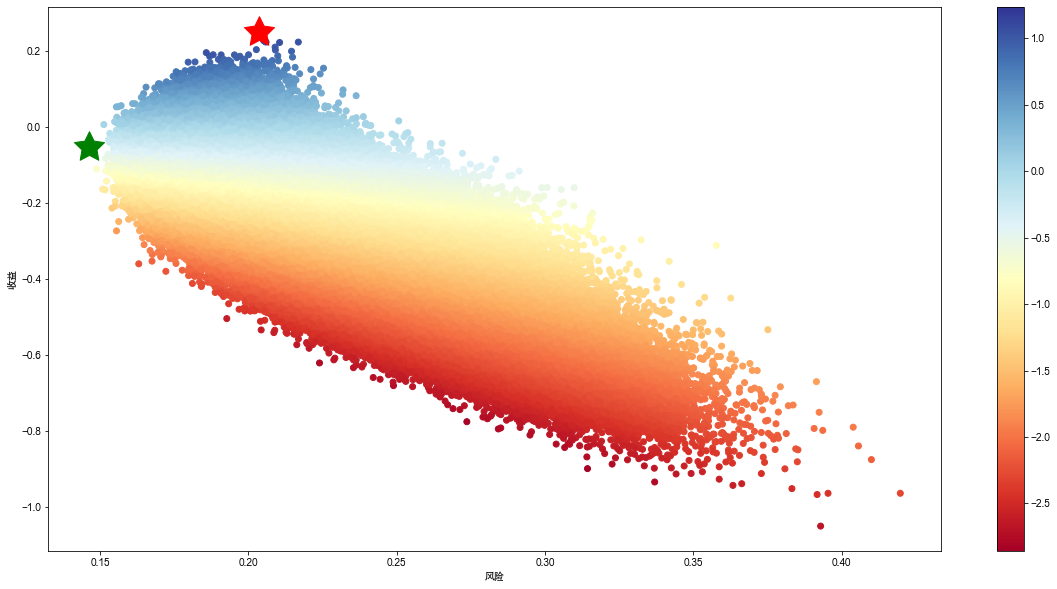

In [129]:
import time
"""
基于权重随机组合，绘制夏普比云图
"""

df_rtn_120 = df_rtn[-120:]
df_rtn_120_columns = mean_daily_returns.index.to_list()
mean_daily_returns = df_rtn_120.mean(axis = 0)
cov_matrix = df_rtn_120.cov()
num_portfolios = 1000000

print('开始时间:', time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) )

results = np.zeros((4+len(df_rtn_120_columns)-1, num_portfolios))

for i in range(num_portfolios):
    weights = np.array(np.random.random(len(df_rtn_120_columns)))
    weights /= np.sum(weights)
    
    portfolio_return = np.sum(mean_daily_returns * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(252)
    
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    #store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
    results[2,i] = results[0,i] / results[1,i]
    for j in range(len(weights)):
        results[j+3,i] = weights[j]
column = ['ret','stdev','sharpe']
column.extend(df_rtn_120_columns)
results_frame = pd.DataFrame(results.T, columns=column)

max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]

print('计算结束:', time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) )
print(results_frame[results_frame['sharpe'] == results_frame['sharpe'].max()])
print(results_frame[results_frame['stdev'] == results_frame['stdev'].min()])
plt.figure(figsize=(20,10))
plt.scatter(results_frame.stdev, results_frame.ret, c=results_frame.sharpe, cmap='RdYlBu')
plt.xlabel('风险')
plt.ylabel('收益')
plt.colorbar()
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=1000)
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=1000);

### 简单说明几点

- 如上计算得到的协方差是最简单的估算方式，用过去三年的历史数据来估计日收益率的协方差矩阵，然后年化

- 做得更好一点可以加一些对协方差矩阵的预测，常用的可以比如有EWMA、对角元和非对角元采用不同的方法处理、GARCH建模（具体思路可以借鉴barra risk model handbook）

- 在得到协方差矩阵之后，就要构建组合，使得组合的风险最小

### 组合优化
---

- 根据前文描述，我们的组合构建可以简化为求解如下最优问题
$$min \quad  \frac{1}{2}\boldsymbol \omega' \boldsymbol \Omega \boldsymbol \omega$$
$$\boldsymbol w' \boldsymbol1 = 1$$
$$ w_i \geq 0$$
        其中$\boldsymbol \Omega 就是我们估计出来的协方差矩阵，\boldsymbol w即为我们需要优化出来的各个资产的权重$
        
- 在$\boldsymbol w$没有非负约束的条件下可以引入拉格朗日乘子，求解得到上述优化问题的封闭解，如下所示
$$\boldsymbol w^* = \frac{\boldsymbol \Omega^{-1}\boldsymbol 1}{\boldsymbol 1' \boldsymbol \Omega^{-1} \boldsymbol 1}$$

- 实际中，由于A股的不好轻易做空限制，在优化组合时都会加上非空的限制，这个时候就需要利用优化器进行优化

- 可以看到需要优化的是一个简单的二次优化问题，用python中的CVXOPT可轻松求解，关于CVXOPT的用法可以参见我的另一篇帖子[`如何在Python中利用CVXOPT求解二次规划问题`](https://uqer.io/community/share/55c9a55df9f06c91f818c675)
---
#### 这里还是简单回顾下，并做最细一步的讲解
二次规划问题的标准形式如下：
$$min \quad  \frac{1}{2}x'Px+qx$$
$$s.t.\quad Gx\leq h$$
$$Ax=b$$
然后将我们的优化问题转换为如上的形式，`找到对应的P、q、G、h、A、b，带入优化函数即可求解`：
$$min \quad  \frac{1}{2} \omega' \Omega \omega$$

$$s.t.\begin{pmatrix} -1  & \cdots & 0 &  0 \\ 0 & -1 &  \cdots & 0 \\ \vdots & \vdots & \vdots &  \vdots \\ 0 & 0 &  \cdots & -1 \end{pmatrix}_{n*n} \begin{pmatrix} \omega_1 \\ \omega_2 \\ \vdots \\ \omega_n \end{pmatrix} \leq \begin{pmatrix} 0 \\ 0 \\ \vdots \\ 0 \end{pmatrix}$$
$$\begin{pmatrix} 1  & \cdots & 1 &  1 \end{pmatrix}_{1*n} \begin{pmatrix} \omega_1 \\ \omega_2 \\ \vdots \\ \omega_n \end{pmatrix} = 1$$

所以可以很容易得到
$$P=\boldsymbol \Omega$$
$$q=\begin{pmatrix} 0 \\ 0 \\ \vdots \\ 0 \end{pmatrix}$$
$$G=\begin{pmatrix} -1  & \cdots & 0 &  0 \\ 0 & -1 &  \cdots & 0 \\ \vdots & \vdots & \vdots &  \vdots \\ 0 & 0 &  \cdots & -1 \end{pmatrix}$$
$$h=\begin{pmatrix} 0 \\ 0 \\ \vdots \\ 0 \end{pmatrix}$$
$$A=\begin{pmatrix} 1  & \cdots & 1 &  1 \end{pmatrix}$$
$$b=\begin{pmatrix}1 \end{pmatrix}$$
---
#### 下面就用前面得到的cov_mat来完整实现一遍优化过程

In [57]:
# 根据上面的描述写好对应的P、q、G、h、A、b
Nums = cov_mat.shape[0]
P = matrix(cov_mat.values)
q = matrix(np.zeros(Nums))
G = matrix(np.diag(-np.ones(Nums)))
h = matrix(np.zeros(Nums))
A = matrix(np.ones(Nums)).T
b = matrix(1.0).T

# 代入优化方程求解
sol = solvers.qp(P, q, G, h, A, b)
wts = pd.Series(index=cov_mat.index, data=np.array(sol['x']).flatten())
wts#.head()

     pcost       dcost       gap    pres   dres
 0:  1.3569e-02 -1.0092e+00  1e+00  0e+00  5e+00
 1:  1.3266e-02 -1.8883e-02  3e-02  5e-17  2e-01
 2:  7.1325e-03 -1.1232e-03  8e-03  7e-17  3e-17
 3:  4.9163e-03  3.5355e-03  1e-03  1e-16  2e-17
 4:  4.3990e-03  4.1037e-03  3e-04  2e-16  7e-18
 5:  4.2426e-03  4.2120e-03  3e-05  3e-16  8e-18
 6:  4.2250e-03  4.2233e-03  2e-06  1e-16  7e-18
 7:  4.2238e-03  4.2237e-03  1e-07  1e-16  8e-18
 8:  4.2238e-03  4.2237e-03  2e-09  2e-16  1e-17
Optimal solution found.


300ETF    5.592034e-09
全指金融      1.322236e-08
银行基金      8.573971e-02
证券ETF     4.459797e-09
酒ETF      3.209606e-03
医药ETF     8.101087e-07
军工基金      2.892601e-07
传媒ETF     7.700550e-02
新能车       1.159788e-09
有色金属      9.268713e-10
环保ETF     2.339635e-09
5GETF     7.244427e-03
500ETF    2.470981e-01
农业ETF     1.748162e-07
科创50      3.289888e-06
化工ETF     1.731048e-09
纳指ETF     9.320524e-09
标普500     5.796981e-01
中概互联      3.101146e-09
中小板       4.618086e-09
dtype: float64

#### 如上，我们便得到了最小方差下的权重配置方案，接下来就看看回测结果如何，先简单说明几点
---
- 回测之前，先将回测过程中可能用到的函数都打包在下面的cell

- 回测过程采用了动态universe的方式，规避了幸存者偏差，平时不清楚这个概念的矿友们可以认真研读下这篇文章：[`量化策略七宗罪`](http://wallstreetcn.com/node/263186)

- 对于最小方差组合，可千万别期待其在收益上有多么牛逼的表现，更应该关注其波动


In [4]:
# 获取数据
data = DataSource('bar1d_CN_FUND').read(instruments, (pd.to_datetime(start_date) - datetime.timedelta(days=200)).strftime('%Y-%m-%d'), end_date, fields=['close'])  # 基于回测结束日期向前多取200天数据

# 整理数据
data = pd.pivot_table(data, values='close', index=['date'], columns=['instrument'])
# print(data)

# 处理复权数据
for i in range(len(instruments)):
    if instruments[i] == '512690.HOF':
        data.loc[:'2021-05-14', '512690.HOF'] = data.loc[:'2021-05-14', '512690.HOF'] / 1.961  # 512690.HOF 2021-05-14 之前数据 / 1.961
    elif instruments[i] == '512010.HOF':
        data.loc[:'2021-06-25', '512010.HOF'] = data.loc[:'2021-06-25', '512010.HOF'] / 3.905  # 512010.HOF 2021-06-25 之前数据 / 3.905
    elif instruments[i] == '159928.ZOF':
        data.loc[:'2021-06-24', '159928.ZOF'] = data.loc[:'2021-06-24', '159928.ZOF'] / 4  # 159928.ZOF 2021-06-24 之前数据 / 4

name_list = data.columns.to_list()
for i in range(len(name_list)):
    df_info = DataSource('basic_info_CN_FUND').read(name_list[i])  # 查询基金的基本信息
    if name_list[i] in ['159870.ZOF']:
        name_list[i] = '化工ETF'
    else:
        name_list[i] = df_info.loc[0, 'display_name']

t_data = data.copy()
t_data.columns=name_list
T.plot(t_data, options={'chart':{'height':800}})

In [5]:
def get_cov_mat(secIDs, end_date):
    """
    基于代码获取历史数据的年化协方差矩阵
    """
    df_rtn = pd.DataFrame()
    start_date = (pd.to_datetime(end_date) - datetime.timedelta(days=250)).strftime('%Y-%m-%d')  # 向前推150天
#     print(secIDs)
    for i in range(len(secIDs)):
        df_bar = DataSource('bar1d_CN_FUND').read(secIDs[i], start_date=start_date, end_date=end_date, fields = ['instrument', 'date', 'close'])  # 查询历史行情
        df_bar.dropna(inplace=True)
        if secIDs[i] == '512690.HOF':  # 解决行情的除权，采取后复权
                df_bar['close'] = df_bar.apply(lambda x: round(x['close'] / 1.961, 3) if x['date'] <= pd.to_datetime('2021-05-14') else x['close'], axis=1)  # 512690.HOF 2021-05-14 之前数据 / 1.961
        elif secIDs[i] == '512010.HOF':
            df_bar['close'] = df_bar.apply(lambda x: round(x['close'] / 3.905, 3) if x['date'] <= pd.to_datetime('2021-06-25') else x['close'], axis=1)  # 512010.HOF 2021-06-25 之前数据 / 3.905
        elif secIDs[i] == '159928.ZOF':
            df_bar['close'] = df_bar.apply(lambda x: round(x['close'] / 4, 3) if x['date'] <= pd.to_datetime('2021-06-24') else x['close'], axis=1)  # 159928.ZOF 2021-06-24 之前数据 / 4
#         print(len(df_bar))
#         print(df_bar)
        if len(df_bar) >= 100:  # 去掉历史记录太少的数据
            df_bar[secIDs[i]] = np.log(df_bar['close'] / df_bar['close'].shift(1))
#             df = df_bar[['date',secIDs[i]]].copy()
            if df_rtn.empty:
                df_rtn = df_bar[['date', secIDs[i]]].copy()
            else:
#                 print(df_rtn.head(3))
                df_rtn = df_rtn.merge(df_bar[['date',secIDs[i]]], on=['date'], how='outer')
            
    df_rtn.set_index('date', drop=True, inplace=True)
    df_rtn = df_rtn[1:]
    df_rtn.fillna(0, inplace=True)
#     df_rtn.sort_values(by='date', ascending=False, inplace=True)  # 逆序
#     print(df_rtn.tail())
    return df_rtn.ewm(20).cov()*252, df_rtn*252  # 一年大概252个交易日，采取年化是业内通用做法

def get_weights(cov_mat):
    """
    基于年化方差协方差矩阵估计最优化，简化版，去掉收益的期望
    """
    Nums = cov_mat.shape[0]
    P = matrix(cov_mat.values)  # 求最小风险
    q = matrix(np.zeros(Nums))
    G = matrix(np.diag(np.ones(Nums)))  # 求最小风险
    h = matrix(0.25, (Nums ,1))  # 单只个股持仓最大值
    A = matrix(np.ones(Nums)).T
    b = matrix(1.0).T

    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b)
    wts = pd.Series(index=cov_mat.index, data=np.array(np.round(sol['x'],3)).flatten())
    wts = wts[wts >= 0.01]  # weights调整，对于权重太小的不予配置
    wts_adjusted = wts / wts.sum() * 1.0
    return wts_adjusted

def get_weights_min_variance(cov_mat, exp_rtn, risk_aversion, single_asset_capacity):
    """
    基于年化方差协方差矩阵估计最优化，增加收益的期望
    """
    Nums = cov_mat.shape[0]
    exp_rtn = exp_rtn[-20:].mean(axis = 0)
    P = risk_aversion * matrix(cov_mat.values)
    q = -1 * matrix(exp_rtn.values)  # 收益的期望取最近20个交易日的收益率均值
    G = matrix(np.vstack((np.diag(np.ones(len(exp_rtn))), np.diag(-np.ones(len(exp_rtn))))))
    h = matrix(np.array([np.ones(len(exp_rtn)) * single_asset_capacity, np.zeros(len(exp_rtn))]).reshape(len(exp_rtn)*2,1))  # 上半部分为单只仓位的控制，下半部分为非零约束
    A = matrix(np.ones(len(exp_rtn)),(1,len(exp_rtn)))
    b = matrix(1.0).T
    
    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b)
    wts = pd.Series(index=cov_mat.index, data=np.array(np.round(sol['x'],3)).flatten())
    wts = wts[wts >= 0.01]  # weights调整，对于权重太小的不予配置
    wts_adjusted = wts / wts.sum() * 1.0
    return wts_adjusted

def get_weights_max_diversification(cov_mat, exp_rtn, risk_aversion, single_asset_capacity):
    """
    获得以此估计出来的年化方差协方差矩阵，增加风险厌恶系数和最大仓位约束
    """
    Nums = cov_mat.shape[0]
    exp_rtn = exp_rtn[-20:].mean(axis = 0)
    P = -1 * risk_aversion * matrix(cov_mat.values)
    q = matrix(exp_rtn.values)  # 收益的期望取最近20个交易日的收益率均值
    G = matrix(np.vstack((np.diag(np.ones(len(exp_rtn))), np.diag(-np.ones(len(exp_rtn))))))
    h = matrix(np.array([np.ones(len(exp_rtn)) * single_asset_capacity, np.zeros(len(exp_rtn))]).reshape(len(exp_rtn)*2,1))  # 上半部分为单只仓位的控制，下半部分为非零约束
    A = matrix(np.ones(len(exp_rtn)),(1,len(exp_rtn)))
    b = matrix(1.0).T

    # 代入优化方程求解
    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b)
#     wts = pd.Series(index=cov_mat.index, data=np.array(sol['x']).flatten())
    wts = pd.Series(index=cov_mat.index, data=np.array(np.round(sol['x'],3)).flatten())
    wts = wts[wts >= 0.01]  # weights调整，对于权重太小的不予配置
    wts_adjusted = wts / wts.sum() * 1.0
    return wts_adjusted


def rebalance_signal(portfolio, original_position, today):
    """
    总体的仓位控制
    """
    if portfolio.cash / portfolio.portfolio_value > 0.25:
        print(today, '：现金仓位超过25%，触发重新配仓')
        return True
    elif (portfolio.positions_value - original_position)/original_position < -0.1:
        print(today, '：仓位跌幅超过10%，触发重新配仓')
        return True
    elif (portfolio.positions_value - original_position)/original_position > 0.25:
        print(today, '：仓位涨幅超过25%，触发重新配仓')
        return True
    else:
        return False

def get_before_tradeday(date, n):
    """
    获取指定日期前的交易日日期
    """
    today = date
    today_datetime = datetime.datetime.strptime(today,"%Y-%m-%d")
    past_datetime = today_datetime - datetime.timedelta(days=n)
    past = past_datetime.strftime("%Y-%m-%d")
    return past

def valudate_input_type(valudate_data, valudate_type):
    """
    格式校验
    """
    if not isinstance(valudate_data, valudate_type):
        print('输入矩阵不匹配校验格式', str(valudate_type))
        return False
    else:
        return True

def calculate_risk_contribution(w,V):
    """
    计算资产对组合风险的贡献
    """
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # Marginal Risk Contribution
    MRC = V*w.T
    # Risk Contribution
    RC = np.multiply(MRC,w.T)/sigma
    return RC
    
def get_weight_scipy_opt(cov_mat, exp_rtn, method, wts_adjusted):
    '''
    功能：输入协方差矩阵，得到不同优化方法下的权重配置
    输入：
        cov_mat  pd.DataFrame,协方差矩阵，index和column均为资产名称
        method  优化方法，可选的有 min_var、risk_parity、max_div、mean_weights、mean_vol
    输出：
        pd.Series  index为资产名，values为weight
    '''
    if not valudate_input_type(cov_mat, pd.DataFrame):
        return
        
    omega = np.matrix(cov_mat.values)  # 协方差矩阵
    
    def fun1(x):
        # 最小方差
#         return np.matrix(x) * omega * np.matrix(x).T
        return np.dot(x.T, np.dot(cov_mat,x))  # 这里的风险是一个对投资组合风险的总衡量
    
    def fun2(x):
        # 风险平价
        tmp = (omega * np.matrix(x).T).A1
#         risk = x * tmp
        risk = x * tmp/ np.sqrt(np.matrix(x) * omega * np.matrix(x).T).A1[0]
        delta_risk = [sum((i - risk)**2) for i in risk]
#         print(sum(delta_risk))
        return sum(delta_risk)
    
    def fun3(x):
        # 最大分散比
        x = np.asmatrix(x)
        cov = np.asmatrix(omega)
        vol = np.diagonal(cov)
        w_vol = np.sum(np.multiply(x, vol))
        port_vol = np.sqrt((x * cov * x.T)[0, 0])
        return -w_vol/port_vol
    
    # 初始值 + 约束条件 
    x0 = np.ones(omega.shape[0]) / omega.shape[0]  
    bnds = tuple((0, None) for x in x0)
    cons = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1.0},)  # 总权重约束
    cons = cons + ({'type': 'ineq', 'fun': lambda x: x},)  # 仅做多约束
    cons = cons + ({'type': 'ineq', 'fun': lambda x: 0.5 - x},)  # 单仓位约束不高于50%
    options={'disp':False, 'maxiter':1000, 'ftol':1e-5}
    
    # 执行优化解算
    if method in['min_var', 'risk_parity', 'max_div']:
        if method == 'min_var':  # 组合方差最小时权重
            res = minimize(fun1, x0, bounds=bnds, constraints=cons, method='SLSQP', options=options)
        elif method == 'risk_parity':  # 风险平价
            res = minimize(fun2, x0, bounds=bnds, constraints=cons, method='SLSQP', options=options)
        elif method == 'max_div':  # 最大分散比
            bnds = [(max(0, x[0]), x[1]) for x in bnds]
            res = minimize(fun3, x0, bounds=bnds, constraints=cons, method='SLSQP', options=options)
    #         print(res)
        if not res['success']:
            print('有多解存在，返回次优解，调仓方案需人工斟酌')
        wts = pd.Series(index=cov_mat.index, data=np.array(np.round(res['x'],3)).flatten())  # 大部分情况下无最优解，只能给出次优解
    else:
        if method == 'mean_weights':  # 平均分配权重
            res = np.array([1.0 / exp_rtn.shape[1]] * exp_rtn.shape[1])
        elif method == 'mean_vol':  # 等波动率
            res = 1/np.sqrt(exp_rtn.std())
            res =  res/res.sum()
        wts = pd.Series(index=cov_mat.index, data= res)
    
    # 权重调整
    if wts_adjusted:
        wts = wts[wts >= 0.02]
        return wts / wts.sum() * 1.0
    elif not wts_adjusted:
        return wts

In [6]:
# 初始化账户
def initialize(context):
    context.set_commission(PerOrder(buy_cost=0.00001, sell_cost=0.00001, min_cost=0.2)) # 设置手续费，买入成本为万分之1
    context.original_position = 0

def handle_data(context, data):
    today = data.current_dt.strftime('%Y-%m-%d')  # 获取今日的日期字符串
    
    if rebalance_signal(context.portfolio, context.original_position, today) or context.trading_day_index % 21 == 0:  # 按月调仓
#     if rebalance_signal(context.portfolio, context.original_position) or data.current_dt.weekday() == 0:  # 按周调仓
        print('=' * 100)
        cash = context.portfolio.cash  # 现金
        cur_position = {e.symbol: p.available_close_amount
                 for e, p in context.portfolio.positions.items()}
        
        # 核心优化逻辑
        cov, rtn = get_cov_mat(instruments, today)
#         print(rtn)
#         print(cov)
        cov = cov.sort_index()
        cov = cov.loc[today, :]  # 基于加权协方差矩阵，取当天的结果
        cov.index = cov.index.droplevel()
        try:
    #         print(cov)
    #         wts = get_weights(cov).to_dict() # 最小协方差，去除期望收益
    #         wts = get_weights_min_variance(cov, rtn, 2, 0.25).to_dict() # 最小协方差，保留期望收益的影响
    #         wts = get_weights_max_diversification(cov, rtn, 2, 0.30).to_dict() # 最大多元化组合
            wts = get_weight_scipy_opt(cov, rtn, method='min_var', wts_adjusted=True)  # min_var、risk_parity、mean_weights、mean_vol、max_div

            if len(wts):
                print('日期：', today, '，当前现金：', cash, '，仓位：', cur_position)

                # 交易逻辑
#                 print('交易计划：', wts)
                stock_hold_now = [equity.symbol for equity in context.portfolio.positions]  # 获取目前持仓的股票列表
                sell_list = [stk for stk in stock_hold_now if stk not in list(wts.keys())]  # 确认是否有不在买入名单中的票，有就全部卖掉
                for stk in sell_list:
        #             print('卖出股票：', sell_list)
                    context.order_target(stk, 0)

                for key, value in wts.items():  # 按照权重方案，完成买入
        #             print('买入股票和仓位：', key, value)
                    try:
                        if data.can_trade(context.symbol(key)):
                            context.order_target_percent(key, value)
                        context.original_position = context.portfolio.positions_value  # 保存当前调仓后的市值
                    except:
                        print(key, '买入失败')
        except:
            return
    else:
        return

m=M.trade.v4(
    instruments=instruments,
    start_date=start_date,
    end_date=end_date,
    initialize=initialize,
    handle_data=handle_data,
    volume_limit=0.025,
    order_price_field_buy='open',
    order_price_field_sell='open',
    capital_base=1000000, # 本金
    auto_cancel_non_tradable_orders=True,
    data_frequency='daily',
    price_type='真实价格',
    product_type='股票',
    plot_charts=True,
    backtest_only=False,
    benchmark='000300.INDX',  # 计算基准的业绩水平
    # 2019-01-01 ~ 2021-08-12 收益率 65.19%， alpha 0.02， beta 1， 夏普比 1， 胜率 1， 盈亏比 0， 收益波动率 21.57%， 信息比 0.05， 最大回撤 17.16%
    )

[2021-08-24 11:39:21.869197] INFO: moduleinvoker: backtest.v8 开始运行..

[2021-08-24 11:39:21.873565] INFO: backtest: biglearning backtest:V8.5.0

[2021-08-24 11:39:21.874676] INFO: backtest: product_type:stock by specified

[2021-08-24 11:39:22.688251] INFO: moduleinvoker: cached.v2 开始运行..

[2021-08-24 11:39:24.888470] INFO: backtest: 读取基金行情完成:14203

[2021-08-24 11:39:24.982497] INFO: moduleinvoker: cached.v2 运行完成[2.294252s].

[2021-08-24 11:39:25.040583] INFO: algo: TradingAlgorithm V1.8.5

[2021-08-24 11:39:25.508344] INFO: algo: trading transform...

2019-01-02 ：现金仓位超过25%，触发重新配仓


日期： 2019-01-02 ，当前现金： 1000000.0 ，仓位： {}
2019-01-03 ：现金仓位超过25%，触发重新配仓


日期： 2019-01-03 ，当前现金： 741019.0471157595 ，仓位： {'159928.ZOF': 50600, '512680.HOF': 227400, '512700.HOF': 31500}
2019-01-04 ：现金仓位超过25%，触发重新配仓


日期： 2019-01-04 ，当前现金： 615489.6129372531 ，仓位： {'159928.ZOF': 112100, '512680.HOF': 204300, '512700.HOF': 65700}
2019-01-07 ：现金仓位超过25%，触发重新配仓


日期： 2019-01-07 ，当前现金： 406162.37261223095 ，仓位： {'159928.ZOF': 193500, '512680.HOF': 219900, '512700.HOF': 121100}
2019-01-08 ：现金仓位超过25%，触发重新配仓


日期： 2019-01-08 ，当前现金： 494144.19607610506 ，仓位： {'159928.ZOF': 216000, '512700.HOF': 138600}
2019-01-09 ：现金仓位超过25%，触发重新配仓


日期： 2019-01-09 ，当前现金： 365991.3984347144 ，仓位： {'159928.ZOF': 280600, '512700.HOF': 150800}
2019-01-10 ：现金仓位超过25%，触发重新配仓


日期： 2019-01-10 ，当前现金： 352737.97621913976 ，仓位： {'159928.ZOF': 278900, '512700.HOF': 168300}
2019-01-11 ：现金仓位超过25%，触发重新配仓


日期： 2019-01-11 ，当前现金： 350425.98915747134 ，仓位： {'159928.ZOF': 279400, '512700.HOF': 169800}
2019-01-14 ：现金仓位超过25%，触发重新配仓


日期： 2019-01-14 ，当前现金： 460387.81143017707 ，仓位： {'159928.ZOF': 186000, '512700.HOF': 171100, '512400.HOF': 52600, '512680.HOF': 47600}
2019-01-15 ：现金仓位超过25%，触发重新配仓


日期： 2019-01-15 ，当前现金： 406647.5452789188 ，仓位： {'159928.ZOF': 195200, '512700.HOF': 172200, '512680.HOF': 149200}
2019-01-16 ：现金仓位超过25%，触发重新配仓


日期： 2019-01-16 ，当前现金： 431076.08832192747 ，仓位： {'159928.ZOF': 152300, '512700.HOF': 173700, '512680.HOF': 234700}
2019-01-17 ：现金仓位超过25%，触发重新配仓


日期： 2019-01-17 ，当前现金： 365320.81682887604 ，仓位： {'159928.ZOF': 152100, '512700.HOF': 175000, '512680.HOF': 334700}
2019-01-18 ：现金仓位超过25%，触发重新配仓


日期： 2019-01-18 ，当前现金： 342954.1156763566 ，仓位： {'159928.ZOF': 163500, '512700.HOF': 184400, '512680.HOF': 322000}
2019-01-21 ：现金仓位超过25%，触发重新配仓


日期： 2019-01-21 ，当前现金： 428869.2689675016 ，仓位： {'159928.ZOF': 97300, '512700.HOF': 188700, '512680.HOF': 382000}
2019-01-22 ：现金仓位超过25%，触发重新配仓


日期： 2019-01-22 ，当前现金： 562404.857416867 ，仓位： {'512700.HOF': 204600, '512680.HOF': 447900}
2019-01-23 ：现金仓位超过25%，触发重新配仓


日期： 2019-01-23 ，当前现金： 353036.2768880883 ，仓位： {'512700.HOF': 212900, '512680.HOF': 488700, '159928.ZOF': 90700}
2019-01-24 ：现金仓位超过25%，触发重新配仓


日期： 2019-01-24 ，当前现金： 309438.4686944615 ，仓位： {'512700.HOF': 223300, '512680.HOF': 542800, '159928.ZOF': 90100}
2019-01-25 ：现金仓位超过25%，触发重新配仓


日期： 2019-01-25 ，当前现金： 297301.87624955317 ，仓位： {'512700.HOF': 238400, '512680.HOF': 305300, '159928.ZOF': 73900, '512200.HOF': 124500, '512580.HOF': 138000}
2019-01-28 ：现金仓位超过25%，触发重新配仓


日期： 2019-01-28 ，当前现金： 276277.6480613481 ，仓位： {'512700.HOF': 256100, '512680.HOF': 307500, '159928.ZOF': 54000, '512200.HOF': 160000, '512580.HOF': 160400}
2019-01-29 ：现金仓位超过25%，触发重新配仓


日期： 2019-01-29 ，当前现金： 270170.08311905316 ，仓位： {'512700.HOF': 263600, '512680.HOF': 297200, '159928.ZOF': 54900, '512200.HOF': 168500, '512580.HOF': 156400}


日期： 2019-01-31 ，当前现金： 260399.8660700518 ，仓位： {'512700.HOF': 269800, '512680.HOF': 257700, '159928.ZOF': 84900, '512200.HOF': 157700, '512580.HOF': 122400}
2019-02-01 ：现金仓位超过25%，触发重新配仓


日期： 2019-02-01 ，当前现金： 385322.5412877166 ，仓位： {'512700.HOF': 287000, '512680.HOF': 265900, '512200.HOF': 173400, '512580.HOF': 134400}
2019-02-11 ：现金仓位超过25%，触发重新配仓


日期： 2019-02-11 ，当前现金： 598676.0085782327 ，仓位： {'512700.HOF': 306500, '512200.HOF': 209400}
2019-02-12 ：现金仓位超过25%，触发重新配仓


日期： 2019-02-12 ，当前现金： 548299.265802685 ，仓位： {'512700.HOF': 327400, '512200.HOF': 248200}
2019-02-13 ：现金仓位超过25%，触发重新配仓


日期： 2019-02-13 ，当前现金： 484221.3892417966 ，仓位： {'512700.HOF': 332800, '512200.HOF': 325300}
2019-02-14 ：仓位涨幅超过25%，触发重新配仓


日期： 2019-02-14 ，当前现金： 203977.37048362172 ，仓位： {'512700.HOF': 361500, '512200.HOF': 213400, '159928.ZOF': 134600, '512680.HOF': 81600}


日期： 2019-03-08 ，当前现金： 142735.00444965053 ，仓位： {'512700.HOF': 392200, '512200.HOF': 213700, '159928.ZOF': 148700, '512680.HOF': 81600}


日期： 2019-04-09 ，当前现金： 406.8504665327491 ，仓位： {'159920.ZOF': 134600, '513050.HOF': 297600, '513100.HOF': 231000}
2019-04-10 ：仓位跌幅超过10%，触发重新配仓


日期： 2019-04-10 ，当前现金： 299131.1305400195 ，仓位： {'513050.HOF': 215000, '513100.HOF': 183400, '512680.HOF': 130700, '512700.HOF': 32900}


日期： 2019-05-13 ，当前现金： 218812.7654833689 ，仓位： {'513050.HOF': 241400, '513100.HOF': 179500, '512680.HOF': 149600, '512700.HOF': 69300}
2019-06-03 ：仓位跌幅超过10%，触发重新配仓


日期： 2019-06-03 ，当前现金： 248769.95292795147 ，仓位： {'513050.HOF': 344800, '513100.HOF': 155400, '512700.HOF': 83400}
2019-06-04 ：现金仓位超过25%，触发重新配仓


日期： 2019-06-04 ，当前现金： 455812.52371298056 ，仓位： {'513050.HOF': 319300, '513100.HOF': 79200, '512700.HOF': 95100}
2019-06-05 ：现金仓位超过25%，触发重新配仓


日期： 2019-06-05 ，当前现金： 435034.67436538613 ，仓位： {'513050.HOF': 313100, '513100.HOF': 83400, '512700.HOF': 111000}
2019-06-06 ：现金仓位超过25%，触发重新配仓


日期： 2019-06-06 ，当前现金： 444177.8483794924 ，仓位： {'513050.HOF': 378800, '513100.HOF': 49300, '512700.HOF': 116600}
2019-06-10 ：现金仓位超过25%，触发重新配仓


日期： 2019-06-10 ，当前现金： 424393.60175402777 ，仓位： {'513050.HOF': 499600, '512700.HOF': 130700}
2019-06-11 ：现金仓位超过25%，触发重新配仓


日期： 2019-06-11 ，当前现金： 426342.8074328711 ，仓位： {'513050.HOF': 297400, '512700.HOF': 150000, '512200.HOF': 133700, '513100.HOF': 35500}
2019-06-12 ：现金仓位超过25%，触发重新配仓


日期： 2019-06-12 ，当前现金： 402553.59556732245 ，仓位： {'513050.HOF': 218100, '512700.HOF': 157300, '512200.HOF': 107400, '513100.HOF': 84200}
2019-06-13 ：现金仓位超过25%，触发重新配仓


日期： 2019-06-13 ，当前现金： 397308.8264861889 ，仓位： {'513050.HOF': 244900, '512700.HOF': 167400, '512200.HOF': 57900, '513100.HOF': 86300}
2019-06-14 ：现金仓位超过25%，触发重新配仓


日期： 2019-06-14 ，当前现金： 397354.1828934862 ，仓位： {'513050.HOF': 238400, '512700.HOF': 168100, '512200.HOF': 54100, '513100.HOF': 90000}
2019-06-17 ：现金仓位超过25%，触发重新配仓


日期： 2019-06-17 ，当前现金： 386684.8906866115 ，仓位： {'513050.HOF': 242600, '512700.HOF': 176500, '512200.HOF': 58100, '513100.HOF': 87500}
2019-06-18 ：现金仓位超过25%，触发重新配仓


日期： 2019-06-18 ，当前现金： 373499.0467545659 ，仓位： {'513050.HOF': 235900, '512700.HOF': 190500, '512200.HOF': 58000, '513100.HOF': 89600}
2019-06-19 ：现金仓位超过25%，触发重新配仓


日期： 2019-06-19 ，当前现金： 357530.65145566256 ，仓位： {'513050.HOF': 214900, '512700.HOF': 198600, '512200.HOF': 115100, '513100.HOF': 83400}
2019-06-21 ：现金仓位超过25%，触发重新配仓


日期： 2019-06-21 ，当前现金： 292568.04520401696 ，仓位： {'513050.HOF': 143300, '512700.HOF': 268900, '512200.HOF': 120000, '513100.HOF': 108300}


日期： 2019-07-11 ，当前现金： 260532.6430814499 ，仓位： {'513050.HOF': 140800, '512700.HOF': 287400, '512200.HOF': 96300, '513100.HOF': 121000}


日期： 2019-08-09 ，当前现金： 245956.81582510204 ，仓位： {'512700.HOF': 311400, '512200.HOF': 166000, '513100.HOF': 137300, '512010.HOF': 31900}


日期： 2019-09-09 ，当前现金： 155625.6728407758 ，仓位： {'512700.HOF': 249000, '513100.HOF': 107200, '159920.ZOF': 296800}


日期： 2019-10-16 ，当前现金： 33.0132151824655 ，仓位： {'512700.HOF': 301700, '159920.ZOF': 401100, '512580.HOF': 322400}
2019-10-17 ：现金仓位超过25%，触发重新配仓


日期： 2019-10-17 ，当前现金： 360621.99012457044 ，仓位： {'512200.HOF': 103900, '512690.HOF': 133300, '513100.HOF': 205800}


日期： 2019-11-14 ，当前现金： 219788.7801296747 ，仓位： {'512200.HOF': 250700, '512690.HOF': 142800, '513100.HOF': 206400}


日期： 2019-12-13 ，当前现金： 12699.352914376184 ，仓位： {'512690.HOF': 424900, '513100.HOF': 202200, '159928.ZOF': 31500}
2019-12-16 ：仓位跌幅超过10%，触发重新配仓


日期： 2019-12-16 ，当前现金： 250474.16297797137 ，仓位： {'512690.HOF': 222300, '513100.HOF': 197100, '159928.ZOF': 35700, '512400.HOF': 400}


日期： 2020-01-14 ，当前现金： 107318.06527537608 ，仓位： {'512690.HOF': 125000, '513100.HOF': 198600, '159928.ZOF': 121200}


日期： 2020-02-20 ，当前现金： 19193.495136336423 ，仓位： {'512690.HOF': 520600, '513100.HOF': 193000}
2020-02-28 ：仓位跌幅超过10%，触发重新配仓


日期： 2020-02-28 ，当前现金： 54155.15516034688 ，仓位： {'513100.HOF': 178600, '513050.HOF': 415800}


日期： 2020-03-20 ，当前现金： 2869.2907924174797 ，仓位： {'513050.HOF': 438400, '159920.ZOF': 434200}


日期： 2020-04-21 ，当前现金： 276.02714493020903 ，仓位： {'513050.HOF': 424800, '159920.ZOF': 184800, '159928.ZOF': 102300, '513100.HOF': 13100}
2020-04-22 ：仓位跌幅超过10%，触发重新配仓


日期： 2020-04-22 ，当前现金： 308923.55763270473 ，仓位： {'159928.ZOF': 195700, '512200.HOF': 379100}
2020-04-23 ：仓位涨幅超过25%，触发重新配仓


日期： 2020-04-23 ，当前现金： 209.6280668078689 ，仓位： {'159928.ZOF': 191900, '512200.HOF': 399600, '513050.HOF': 205100}


日期： 2020-05-25 ，当前现金： 2348.2280613178154 ，仓位： {'159928.ZOF': 191000, '512200.HOF': 403500, '513050.HOF': 203500}


日期： 2020-06-23 ，当前现金： 96.83566382888239 ，仓位： {'159928.ZOF': 190500, '513050.HOF': 414400}


日期： 2020-07-24 ，当前现金： 5991.443910144386 ，仓位： {'159928.ZOF': 199200, '512200.HOF': 539000, '512400.HOF': 228000, '512580.HOF': 127100}
2020-07-27 ：仓位跌幅超过10%，触发重新配仓


日期： 2020-07-27 ，当前现金： 265972.5834070337 ，仓位： {'512980.HOF': 590400, '513100.HOF': 215500}
2020-08-21 ：仓位涨幅超过25%，触发重新配仓


日期： 2020-08-21 ，当前现金： 171.29632296250202 ，仓位： {'512980.HOF': 864700, '513100.HOF': 215500}


日期： 2020-08-24 ，当前现金： 20586.150183802703 ，仓位： {'513100.HOF': 210700, '159920.ZOF': 40700, '162411.ZOF': 1449100, '513050.HOF': 206900}


日期： 2020-09-22 ，当前现金： 10833.845234530396 ，仓位： {'513100.HOF': 208300, '513050.HOF': 439600}


日期： 2020-10-29 ，当前现金： 25691.093556884793 ，仓位： {'513050.HOF': 468100, '159920.ZOF': 700900}
2020-10-30 ：现金仓位超过25%，触发重新配仓


日期： 2020-10-30 ，当前现金： 661597.8415848976 ，仓位： {'162411.ZOF': 4492300, '512700.HOF': 287300}
2020-11-02 ：仓位涨幅超过25%，触发重新配仓


日期： 2020-11-02 ，当前现金： 134010.28148207348 ，仓位： {'162411.ZOF': 4493400, '512700.HOF': 168500, '159920.ZOF': 506000}


日期： 2020-11-27 ，当前现金： 117204.56194082473 ，仓位： {'162411.ZOF': 4543000, '512700.HOF': 307800, '159920.ZOF': 391800}


日期： 2020-12-28 ，当前现金： 342.6948936698027 ，仓位： {'159995.ZOF': 557000, '513050.HOF': 235500, '515700.HOF': 692800}
2020-12-29 ：仓位跌幅超过10%，触发重新配仓


日期： 2020-12-29 ，当前现金： 387750.7047403294 ，仓位： {'162411.ZOF': 2997800, '512200.HOF': 450000, '512700.HOF': 758200}


[2021-08-24 11:45:00.191145] INFO: algo: handle_splits get splits [dt:2021-01-12 00:00:00+00:00] [asset:Equity(1 [512700.HOF]), ratio:1.0000525612844282]

[2021-08-24 11:45:00.193167] INFO: Position: position stock handle split[sid:1, orig_amount:757300, new_amount:757260.0, orig_cost:1.1840262118978118, new_cost:1.1841, ratio:1.0000525612844282, last_sale_price:1.2160638754191626]

[2021-08-24 11:45:00.194414] INFO: Position: after split: PositionStock(asset:Equity(1 [512700.HOF]), amount:757260.0, cost_basis:1.1841, last_sale_price:1.215999960899353)

[2021-08-24 11:45:00.195539] INFO: Position: returning cash: 0.2401

2021-01-12 ：仓位涨幅超过25%，触发重新配仓


日期： 2021-01-12 ，当前现金： 13567.876908642473 ，仓位： {'162411.ZOF': 4353100, '512200.HOF': 435400, '512700.HOF': 757260.0}


日期： 2021-01-27 ，当前现金： 7263.92325457884 ，仓位： {'162411.ZOF': 3937800, '512700.HOF': 1101260.0, '159920.ZOF': 58900}


[2021-08-24 11:45:11.144854] INFO: algo: handle_splits get splits [dt:2021-02-22 00:00:00+00:00] [asset:Equity(1 [512700.HOF]), ratio:0.9999474414781151]

[2021-08-24 11:45:11.146783] INFO: Position: position stock handle split[sid:1, orig_amount:581600.0, new_amount:581630.0, orig_cost:1.198750526868534, new_cost:1.1987, ratio:0.9999474414781151, last_sale_price:1.3579286655794964]

[2021-08-24 11:45:11.148119] INFO: Position: after split: PositionStock(asset:Equity(1 [512700.HOF]), amount:581630.0, cost_basis:1.1987, last_sale_price:1.3580000400543213)

[2021-08-24 11:45:11.149237] INFO: Position: returning cash: 0.7735

[2021-08-24 11:45:11.154323] INFO: algo: handle_splits get splits [dt:2021-02-23 00:00:00+00:00] [asset:Equity(1 [512700.HOF]), ratio:1.0000525612844282]

[2021-08-24 11:45:11.155480] INFO: Position: position stock handle split[sid:1, orig_amount:581630.0, new_amount:581599.0, orig_cost:1.1987, new_cost:1.1988, ratio:1.0000525612844282, last_sale_price:1.336070187541916]

[2021-08-24 11:45:11.156638] INFO: Position: after split: PositionStock(asset:Equity(1 [512700.HOF]), amount:581599.0, cost_basis:1.1988, last_sale_price:1.3359999656677246)

[2021-08-24 11:45:11.157766] INFO: Position: returning cash: 0.575

日期： 2021-03-04 ，当前现金： 67287.51630224462 ，仓位： {'512700.HOF': 581599.0, '513050.HOF': 267700, '513100.HOF': 307700}


日期： 2021-04-02 ，当前现金： 396.9355479023652 ，仓位： {'162411.ZOF': 3448400, '512200.HOF': 1509100}


[2021-08-24 11:45:22.040462] INFO: algo: handle_splits get splits [dt:2021-04-08 00:00:00+00:00] [asset:Equity(1 [512700.HOF]), ratio:0.9999474414781151]

[2021-08-24 11:45:22.042326] INFO: Position: position stock handle split[sid:1, orig_amount:953100, new_amount:953150.0, orig_cost:1.3030178115258184, new_cost:1.3029, ratio:0.9999474414781151, last_sale_price:1.2989317512743006]

[2021-08-24 11:45:22.043551] INFO: Position: after split: PositionStock(asset:Equity(1 [512700.HOF]), amount:953150.0, cost_basis:1.3029, last_sale_price:1.2990000247955322)

[2021-08-24 11:45:22.044687] INFO: Position: returning cash: 0.1249

[2021-08-24 11:45:22.051525] INFO: algo: handle_splits get splits [dt:2021-04-12 00:00:00+00:00] [asset:Equity(1 [512700.HOF]), ratio:1.0000525612844282]

[2021-08-24 11:45:22.052551] INFO: Position: position stock handle split[sid:1, orig_amount:953150.0, new_amount:953099.0, orig_cost:1.3029, new_cost:1.303, ratio:1.0000525612844282, last_sale_price:1.2920679644954989]

[2021-08-24 11:45:22.053555] INFO: Position: after split: PositionStock(asset:Equity(1 [512700.HOF]), amount:953099.0, cost_basis:1.303, last_sale_price:1.2920000553131104)

[2021-08-24 11:45:22.054505] INFO: Position: returning cash: 1.1678

日期： 2021-05-07 ，当前现金： 381.1811501116026 ，仓位： {'162411.ZOF': 156100, '512200.HOF': 1605600, '512700.HOF': 953099.0}


日期： 2021-06-07 ，当前现金： 3478.21690522728 ，仓位： {'162411.ZOF': 3138400, '512200.HOF': 1601800}
2021-06-08 ：仓位跌幅超过10%，触发重新配仓


日期： 2021-06-08 ，当前现金： 343711.6375934271 ，仓位： {'162411.ZOF': 3047500, '513100.HOF': 229300}


日期： 2021-07-07 ，当前现金： 210.11281779350247 ，仓位： {'162411.ZOF': 3063400, '513100.HOF': 303600}


日期： 2021-08-05 ，当前现金： 522.0675818980671 ，仓位： {'515700.HOF': 498200, '588000.HOF': 868200}


[2021-08-24 11:45:49.998894] INFO: Performance: Simulated 650 trading days out of 650.

[2021-08-24 11:45:50.000702] INFO: Performance: first open: 2019-01-02 09:30:00+00:00

[2021-08-24 11:45:50.001796] INFO: Performance: last close: 2021-09-01 15:00:00+00:00

[2021-08-24 11:45:51.743354] INFO: moduleinvoker: backtest.v8 运行完成[389.874159s].

[2021-08-24 11:45:51.744850] INFO: moduleinvoker: trade.v4 运行完成[391.453321s].

In [148]:
# m.raw_perf.read_df()  # 策略的回测源数据
# m.pyfolio_full_tear_sheet()  # 策略收益分析，报错
# m.risk_analyze()  # 风险分析，报错
# m.factor_profit_analyze()  # 风格因子分析，报错
brinson = m.brinson_analysis()
brinson.plot_return_path()
brinson.plot_periods_return_analysis()

KeyError: nan

In [24]:
cov_mat = pd.DataFrame([[0.01, 0.2, 0.25, 0.3], [0.2, 0.26, 0.4, 0.6], [0.25, 0.4, 0.98, 0.6], [0.3, 0.6, 0.6, 0.74]])
exp_rtn = pd.DataFrame([[-0.01, 0.01, 0.05, 0.03], [0.01, 0.07, 0.05, -0.03], [0.03, -0.01, 0.01, -0.03], [-0.10, 0.01, -0.05, 0.13]])
Nums = 4
# 最小方差组合，去掉期望收益
P = matrix(cov_mat.values)
q = matrix(np.zeros(Nums))
G = matrix(np.diag(np.ones(Nums)))
h = matrix(0.25, (Nums, 1))
A = matrix(np.ones(Nums)).T
b = matrix(1.0).T

# 最大投资效应
risk_aversion = 1
single_asset_capacity = 0.25
P = risk_aversion * matrix(cov_mat.values)
q = -1 * matrix(exp_rtn.values)
G = matrix(np.vstack((np.diag(np.ones(len(exp_rtn))),np.diag(-np.ones(len(exp_rtn))))))
h = matrix(np.array([np.ones(len(exp_rtn)) * single_asset_capacity, np.zeros(len(exp_rtn))]).reshape(len(exp_rtn)*2,1))
A = matrix(np.ones(len(exp_rtn)),(1,len(exp_rtn)))
b = matrix([1.0])

# z = matrix(np.array([np.ones(4) * 2, np.zeros(4)]).reshape(4*2,1))
# n=4
# h = opt.matrix(0.2, (n ,1))
# A = opt.matrix(1.0, (1, n))
# b = opt.matrix(1.0)
# t = np.eye(n)

# print("cov_mat:\n",cov_mat)
# print("exp_rtn:\n",exp_rtn)
print("P:\n", P)
print("q:\n", q)
print("G:\n", G)
print("h:\n", h)
print("A:\n", A)
print("b:\n", b)

P:
 [ 1.00e-02  2.00e-01  2.50e-01  3.00e-01]
[ 2.00e-01  2.60e-01  4.00e-01  6.00e-01]
[ 2.50e-01  4.00e-01  9.80e-01  6.00e-01]
[ 3.00e-01  6.00e-01  6.00e-01  7.40e-01]

q:
 [ 1.00e-02 -1.00e-02 -5.00e-02 -3.00e-02]
[-1.00e-02 -7.00e-02 -5.00e-02  3.00e-02]
[-3.00e-02  1.00e-02 -1.00e-02  3.00e-02]
[ 1.00e-01 -1.00e-02  5.00e-02 -1.30e-01]

G:
 [ 1.00e+00  0.00e+00  0.00e+00  0.00e+00]
[ 0.00e+00  1.00e+00  0.00e+00  0.00e+00]
[ 0.00e+00  0.00e+00  1.00e+00  0.00e+00]
[ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]
[-1.00e+00  0.00e+00  0.00e+00  0.00e+00]
[ 0.00e+00 -1.00e+00  0.00e+00  0.00e+00]
[ 0.00e+00  0.00e+00 -1.00e+00  0.00e+00]
[ 0.00e+00  0.00e+00  0.00e+00 -1.00e+00]

h:
 [ 2.50e-01]
[ 2.50e-01]
[ 2.50e-01]
[ 2.50e-01]
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]

A:
 [ 1.00e+00  1.00e+00  1.00e+00  1.00e+00]

b:
 [ 1.00e+00]



### 总结
---
- 从回测结果上看，最小方差组合收益表现很一般，这一点正如前文的预期一致，因为该方法所追求的就是波动小，而实证结果也显示，组合年化波动率为27.6%，低于基准的31.2%
- 另外，本篇的目的在于深入浅出介绍理论与方法，对于很多可以优化的参数只做了最一般的处理，对参数优化感兴趣的朋友可以下去自行研究
- 最后，对收益感兴趣的朋友可以关注后续文章，风险平价配置方法risk parity